<a href="https://colab.research.google.com/github/Roger-G/Data-augmentation/blob/master/Classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import package

In [18]:
import re
from sklearn.utils import resample
import unicodedata
import torch
from sklearn.metrics import precision_recall_fscore_support as score
import torch.nn as nn
from torch.autograd import Variable
import seaborn as sns
from torch import optim
import torch.nn.functional as F
import pickle
import csv
import torch.utils.data as Data
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

from tqdm import trange
import pandas as pd
import torchtext.vocab as Vocab
import collections
import numpy as np
import os
import os.path as path

from sklearn.model_selection import train_test_split
from torchtext import data, datasets
PAD, BOS, EOS = '<pad>', '<bos>', '<eos>'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch.optim as optim


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data process

In [0]:
class Preprocessor():
    
  def __init__(self, data, max_seq_len, vocab):
    self.data = data
    self.max_seq_len = max_seq_len
    self.vocab = vocab
    self.PAD, self.BOS, self.EOS = '<pad>', '<bos>', '<eos>'
    self.all_tokens = []
    self.all_seqs = []

  def process_one_seq(self, seq_tokens):
    self.all_tokens.extend(seq_tokens) # add seq_tokens into one list, like extend the list, [..., seq_tokens].
    seq_tokens = [self.PAD] * (self.max_seq_len - len(seq_tokens)) + seq_tokens
    self.all_seqs.append(seq_tokens) # add seq_tokens become a list element, [...,[seq_tokens]].
      
  def build_data(self):
    if self.vocab:
      indices = [[self.vocab.stoi[w] for w in seq] for seq in self.all_seqs] # use its vocab_dic to represent the sentence. 
    else:
      tokens_dic = collections.Counter(self.all_tokens) 
      self.vocab = Vocab.Vocab(tokens_dic, specials=[self.PAD])
      indices = [[self.vocab.stoi[w] for w in seq] for seq in self.all_seqs] # use its vocab_dic to represent the sentence. 
    return torch.tensor(indices)
  
  @staticmethod
  def normalizeString(s):
    s = s.str.lower()
    s = s.str.replace(r"<br />",r" ")
    s = s.str.replace(r'(\W)(?=\1)', '')
    s = s.str.replace(r"([.!?])", r" \1")
    s = s.str.replace(r"[^a-zA-Z.!?]+", r" ")
    return s

  def read_data(self):
    df = self.data.copy()
    df = df.dropna()
    df['sentence'] = self.normalizeString(df['sentence'])
    df.reset_index(inplace=True, drop=True)
    k = len(df)
    target = []

    for line in range(k):
      in_seq_tokens = df['sentence'][line].split(' ')
      if len(in_seq_tokens) > self.max_seq_len - 1:
        continue
      self.process_one_seq(in_seq_tokens)
      target.append(df.label[line])

    in_data = self.build_data() # in_tokens is the list where contains every word, in_seqs is a list where its element are the sentence in French.

    return Data.TensorDataset(in_data, torch.tensor(target))

## Loading data, path and figure

In [0]:
class Loader():


  def path_setting(self, task_name, tech_name):
    abspath = '/content/drive/My Drive/Data/'
    model_path = path.join(abspath, tech_name + '/save_model')
    dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
    save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))
    
    return model_path, dataset_path, save_path

  @staticmethod
  def load_data(path_, FILE_NAME):

    df_train = pd.read_csv(os.path.join(path_,'train.tsv'), sep='\t',  error_bad_lines=False)
    df_train = df_train.dropna()
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())
    # print('num_DA', num_DA)

    if FILE_NAME != 'oversampling':
      df = pd.read_csv(os.path.join(path_, FILE_NAME + '.tsv'), sep='\t',  error_bad_lines=False)    
      df = df.dropna()
    
    else:
      # 选出差额， 补到原数据上面
      df_over_samp = resample(df_train[df_train.label==0], n_samples=num_DA, random_state=100, replace=True)
      df = pd.concat([df_over_samp, df_train])

    if FILE_NAME != 'train' and FILE_NAME != 'dev' and FILE_NAME != 'oversampling' and FILE_NAME != 'test':
      try:
        df_over_samp = resample(df, n_samples=num_DA, replace = False, random_state=10) 
      except ValueError:
        df_over_samp = resample(df, n_samples=num_DA, replace = True, random_state=10) 

      df = pd.concat([df_train, df_over_samp]) 
    
    else: 
      pass

    df = df.sample(frac=0.1, replace=False, random_state=102)  
    return df

class utils():
  
  def __init__(self, EPOCHS):
    self.EPOCHS = EPOCHS

  def acc_loss(self, list_train_acc, list_val_acc, list_train_loss, list_val_loss):
    fig = plt.figure(figsize=(10, 5))
    
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(ax=ax1, data=pd.DataFrame(list(zip(list_train_acc, list_val_acc)), columns=['training acc', 'validation acc'], index = range(1, len(list_val_acc)+1)))
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.locator_params(integer=True)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.lineplot(ax=ax2, data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=['training loss', 'validation loss'], index = range(1, len(list_val_loss)+1)))
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.locator_params(integer=True)
    plt.show()
  
  @staticmethod
  def draw_final(eval_dic, test_list_name):
    
    for eval_name, eval_list in eval_dic.items():
      sns.set(style="white", context="talk")
      plt.figure(figsize=(10,5)) 
      print('eval_name', eval_name)
      print('eval_list', eval_list)
      g = sns.barplot(x=np.array(eval_list), y=np.array(test_list_name), palette="deep")
      ax=g
    
      for p in ax.patches:
        ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
          fontsize=12, color='gray', xytext=(10, 0), textcoords='offset points')

      ax.axhline(0, color="k", clip_on=False)
      ax.set_xlabel(eval_name)
      # ax.set_ylabel("Methods")

  @staticmethod
  def eval_matrix(list_array_value):
    fig = plt.figure(figsize=(12, 5))
  
    for i, array_value in enumerate(list_array_value):
      df = pd.DataFrame(array_value, columns=["0", "1", "2"], index=range(1,len(array_value)+1))
      ax = fig.add_subplot(1, 3, i+1)
      sns.lineplot(data=df, palette="tab10", ax=ax)
      ax.set(xlabel='Epochs', ylabel=['precision', 'recall', 'fscore'][i])

    plt.show()
  
  @staticmethod
  def draw_other_final(list_array_dic, test_list):

    for eval_name, list_array in list_array_dic.items():
      fig1 = plt.figure(figsize=(10, 5))
      barWidth = 0.07
      colors = ['#486093', '#BF7651', '#4F8F5B', '#A4484E', '#72659A', '#7A6553', '#C47FB2']
      # Set position of bar on X axis
      r1 = np.arange(len(list_array[0]))
      plt.bar(r1, list_array[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
      for i in range(1, len(list_array)):
        r1 = [x + barWidth for x in r1] 
        plt.bar(r1, list_array[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  
    
      # Add xticks on the middle of the group bars
      plt.xlabel('class', fontweight='bold')
      plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['negative', 'neutral', 'positive'])
      plt.ylabel(eval_name)
      # Create legend & Show graphic
      plt.legend()
      plt.show()
    


In [0]:
# dataset_path = pd.read_csv('/content/drive/My Drive/Data/Bert_ data augmentation-master/datasets/twitter/train.tsv', sep='\t')

# import imblearn 
# from imblearn.over_sampling import RandomOverSampler

## Model building

In [0]:
class SentimentRNN(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, num_direct,n_layers, drop_p=0.8):
    super().__init__()
    
    self.output_size = output_size
    self.n_layers = n_layers  
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=drop_p, bidirectional=num_direct, num_layers=n_layers)
    self.fc = nn.Linear(hidden_dim*2 , output_size)
    self.out = nn.Softmax(dim=1)

  
  def forward(self, x):
    # x (batch_size, seq_length) 
    x = self.embedding(x)
    output, hidden = self.lstm(x)
    # print('output', output.shape)
    output = self.fc(output[-1,:,:])
    #print('last output', output.shape)

    return output



In [23]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])
a, b, c, _ = precision_recall_fscore_support(y_true, y_pred)
a 

array([0.66666667, 0.        , 0.        ])

## Train

In [0]:
class Trainer():

  def __init__(self, model, batch_size, patient, learning_rate, N_EPOCHS, file_name):
    self.model = model
    self.batch_size = batch_size
    self.patient = patient
    self.lr = learning_rate
    self.epochs = N_EPOCHS
    self.file_name = file_name
  
  def binary_accuracy(self, pred, label_list):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = 0
    pred_list = pred.tolist()
    pred = [ten.index(max(ten)) for ten in pred.tolist()]
    correct = sum([1 for i in range(len(label_list)) if pred[i]==label_list[i]])
    precision, recall, fscore, _ = score(label_list, pred)
    # macro does not take minor class into account
    _, _, fscore_avg, _ = score(label_list, pred, average='macro')
    # fscore_avg = list(fscore_avg)[0]
    
    self.acc = correct / len(label_list)
    return precision, recall, fscore, fscore_avg


  def train(self, corpus_indices, corpus_indices_valid, corpus_indices_test, model_path):

    best_acc = 0
    best_loss = float('inf')
    loss = nn.CrossEntropyLoss()
    
    data_iter = Data.DataLoader(corpus_indices, self.batch_size, shuffle=True)
    data_iter_dev = Data.DataLoader(corpus_indices_valid , self.batch_size, shuffle=True)
    data_iter_test = Data.DataLoader(corpus_indices_test , len(corpus_indices_test), shuffle=True)
    
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=0)
    # print('optimizer', optimizer)
    draw_train_loss = []
    draw_train_acc = []
    draw_val_loss = []
    draw_val_acc = []
    model_sel = []
    patient = 0

    for epoch in range(self.epochs):
      epoch_loss = []
      epoch_acc = []

      self.model.train()
      for batch in data_iter:
        batch = tuple(t.to(device) for t in batch)
        X, Y = batch[:][0], batch[:][1]
        y_pred = self.model(X.permute(1, 0)).squeeze(1)
        batch__train_loss = loss(y_pred, Y.to(device, dtype=torch.int64))
        self.binary_accuracy(y_pred, Y.tolist())
        batch__train_loss.backward()
        optimizer.step()
        epoch_loss.append(batch__train_loss.item())
        epoch_acc.append(self.acc)

      
      val_loss = []    
      val_acc = []
      self.model.eval()

      for batch in data_iter_dev:

        batch = tuple(t.to(device) for t in batch)
        X, Y = batch[:][0], batch[:][1]
        y_pred = self.model(X.permute(1, 0)).squeeze(1)
        batch_val_loss = loss(y_pred, Y.to(device, dtype=torch.int64))
        self.binary_accuracy(y_pred, Y.tolist())
        val_loss.append(batch_val_loss.item())
        val_acc.append(self.acc)

      if best_acc < np.mean(val_acc):
        best_acc = np.mean(val_acc)
        # patient = 0
      
      
      if best_loss > np.mean(val_loss):

        best_loss = np.mean(val_loss)
        patient = 0
        model_sel = []  

      model_sel.append(self.model)
      
      patient += 1
      if patient > self.patient:
        torch.save(self.model, path.join(model_path,'{}_lstm_cls.pt'.format(self.file_name)))
        break

      print('[epoch %d] train_loss: %.3f, train_acc:%.3f, val Loss: : %.6f, val_acc: %.3f' % 
            (epoch + 1, np.mean(epoch_loss), np.mean(epoch_acc), np.mean(val_loss), np.mean(val_acc)))
      
      draw_train_loss.append(np.mean(epoch_loss)) #计算每个train epoch 的loss和acc 和 val的epoch的loss和acc
      draw_train_acc.append(np.mean(epoch_acc))
      draw_val_loss.append(np.mean(val_loss))
      draw_val_acc.append(np.mean(val_acc))
    
    # torch.save(self.model, path.join(model_path,'{}_lstm_cls.pt'.format(self.file_name)))
    draw = utils(len(draw_train_acc))
    draw.acc_loss(draw_train_acc, draw_val_acc, draw_train_loss, draw_val_loss)

    # 将已经训练好的 model 加载数据    
    '''第一眼看上去是错的，但是其实这个 enumerate· 只有一个，也就是只迭代一次，为的是把 datatest 变成
    GPU 格式'''
    for i, data_test in enumerate(data_iter_test):
      print('i', i)
      data_test = tuple(t.to(device) for t in data_test)
      X, Y = data_test[:][0], data_test[:][1]
      y_pred = model_sel[0](X.permute(1, 0)).squeeze(1)
      test_loss = loss(y_pred, Y.to(device, dtype=torch.int64))
      precision, recall, fscore, fscore_avg = self.binary_accuracy(y_pred, Y.tolist())

    print('acc', self.acc, 'best_train_acc', best_acc)
    print('loss', test_loss.item(), 'best_train_loss', best_loss)

    return self.model, self.acc, test_loss, precision, recall, fscore, fscore_avg


## Execute

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.102, train_acc:0.314, val Loss: : 1.095167, val_acc: 0.372
[epoch 2] train_loss: 1.092, train_acc:0.389, val Loss: : 1.082951, val_acc: 0.424
[epoch 3] train_loss: 1.079, train_acc:0.434, val Loss: : 1.069392, val_acc: 0.443
[epoch 4] train_loss: 1.066, train_acc:0.456, val Loss: : 1.054398, val_acc: 0.432
[epoch 5] train_loss: 1.051, train_acc:0.489, val Loss: : 1.036982, val_acc: 0.447


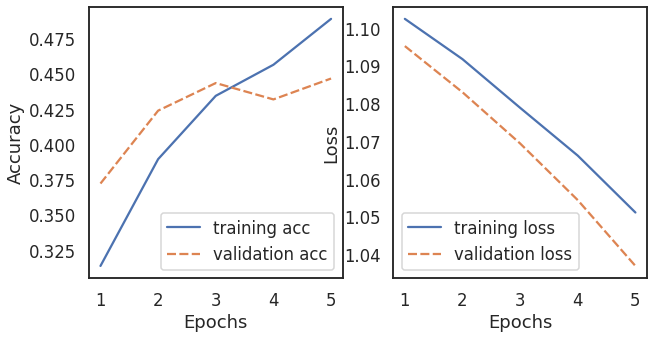

acc 0.5238095238095238 best_train_acc 0.4465029761904762
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.098, train_acc:0.349, val Loss: : 1.101929, val_acc: 0.289
[epoch 2] train_loss: 1.096, train_acc:0.370, val Loss: : 1.103125, val_acc: 0.310
[epoch 3] train_loss: 1.092, train_acc:0.396, val Loss: : 1.105251, val_acc: 0.328
[epoch 4] train_loss: 1.088, train_acc:0.408, val Loss: : 1.104788, val_acc: 0.357


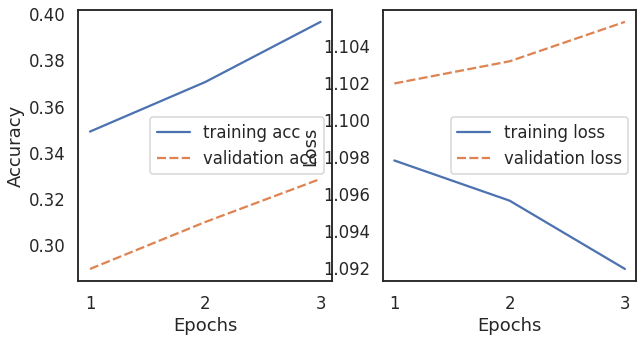

acc 0.47619047619047616 best_train_acc 0.3566220238095238
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.099, train_acc:0.344, val Loss: : 1.109361, val_acc: 0.167
[epoch 2] train_loss: 1.095, train_acc:0.364, val Loss: : 1.111130, val_acc: 0.171
[epoch 3] train_loss: 1.091, train_acc:0.383, val Loss: : 1.112380, val_acc: 0.208
[epoch 4] train_loss: 1.086, train_acc:0.399, val Loss: : 1.112502, val_acc: 0.264


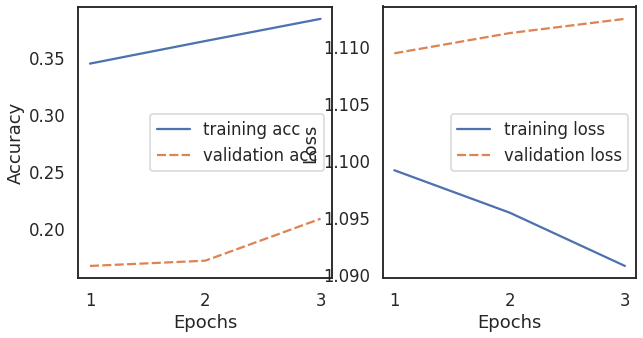

acc 0.3333333333333333 best_train_acc 0.2635416666666667
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.099, train_acc:0.346, val Loss: : 1.108180, val_acc: 0.175
[epoch 2] train_loss: 1.094, train_acc:0.370, val Loss: : 1.110160, val_acc: 0.183
[epoch 3] train_loss: 1.089, train_acc:0.384, val Loss: : 1.110552, val_acc: 0.223
[epoch 4] train_loss: 1.084, train_acc:0.397, val Loss: : 1.111351, val_acc: 0.241


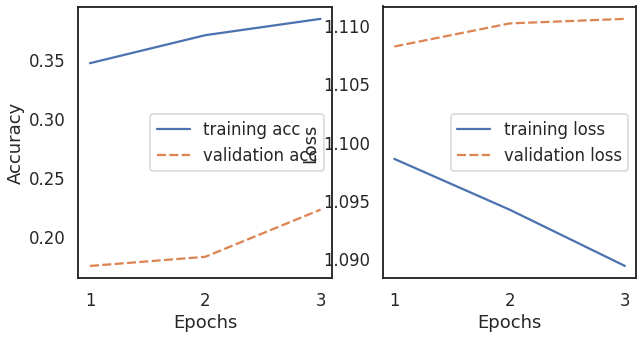

acc 0.19047619047619047 best_train_acc 0.24077380952380953
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.101, train_acc:0.325, val Loss: : 1.114069, val_acc: 0.312
[epoch 2] train_loss: 1.095, train_acc:0.368, val Loss: : 1.111908, val_acc: 0.216
[epoch 3] train_loss: 1.088, train_acc:0.386, val Loss: : 1.108756, val_acc: 0.217
[epoch 4] train_loss: 1.081, train_acc:0.406, val Loss: : 1.106831, val_acc: 0.254
[epoch 5] train_loss: 1.073, train_acc:0.426, val Loss: : 1.103087, val_acc: 0.307


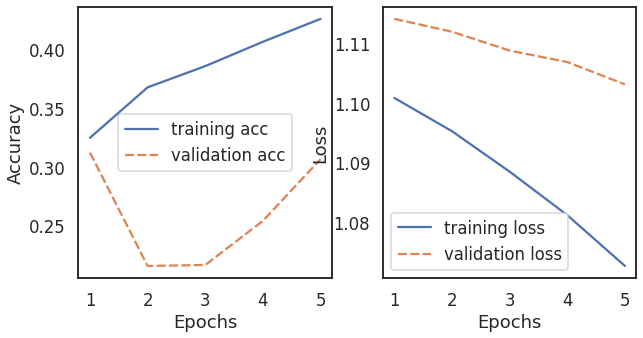

acc 0.38095238095238093 best_train_acc 0.31205357142857143
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.096, train_acc:0.363, val Loss: : 1.104086, val_acc: 0.269
[epoch 2] train_loss: 1.091, train_acc:0.386, val Loss: : 1.107076, val_acc: 0.249
[epoch 3] train_loss: 1.084, train_acc:0.407, val Loss: : 1.109087, val_acc: 0.259
[epoch 4] train_loss: 1.076, train_acc:0.420, val Loss: : 1.109989, val_acc: 0.277


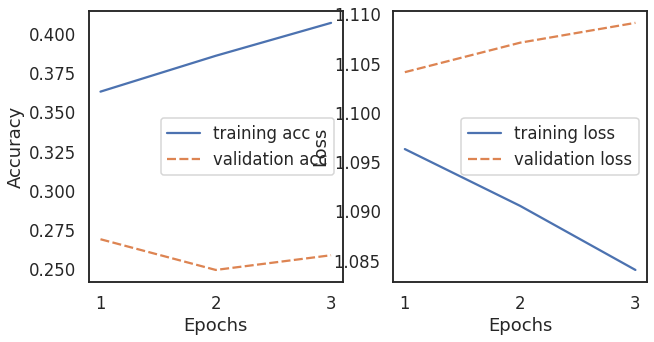

acc 0.19047619047619047 best_train_acc 0.2767113095238095
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 6_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.097, train_acc:0.356, val Loss: : 1.113781, val_acc: 0.156
[epoch 2] train_loss: 1.091, train_acc:0.373, val Loss: : 1.112330, val_acc: 0.177
[epoch 3] train_loss: 1.084, train_acc:0.390, val Loss: : 1.110463, val_acc: 0.235
[epoch 4] train_loss: 1.077, train_acc:0.405, val Loss: : 1.111527, val_acc: 0.277
[epoch 5] train_loss: 1.068, train_acc:0.426, val Loss: : 1.108790, val_acc: 0.307


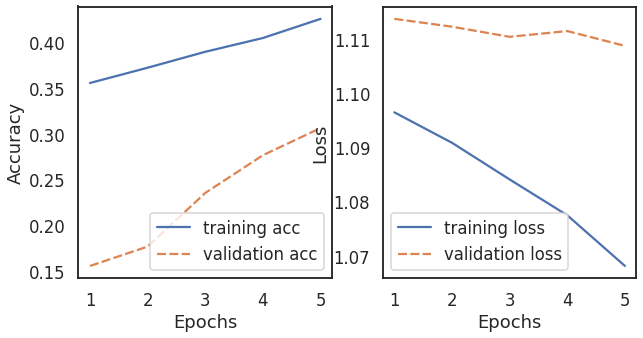

acc 0.38095238095238093 best_train_acc 0.30654761904761907
----------------------------------------------------------------------
acc_list [0.4465029761904762, 0.3566220238095238, 0.2635416666666667, 0.24077380952380953, 0.31205357142857143, 0.2767113095238095, 0.30654761904761907]
loss_list [1.0369819760322572, 1.1019285678863526, 1.1093608796596528, 1.1081795513629913, 1.1030868887901306, 1.1040863990783691, 1.1087896347045898]
precision_list [[0.14285714285714285, 0.5, 0.43478260869565216, 0.3333333333333333, 0.0, 0.3333333333333333, 0.0, 1.0, 0.2857142857142857, 0.0, 0.0, 0.42857142857142855, 0.0, 0.5, 0.38461538461538464, 1.0, 1.0, 0.3, 1.0, 0.4, 0.44, 0.5, 0.0, 0.6071428571428571, 0.0, 0.0, 0.6666666666666666, 0.0, 1.0, 0.3793103448275862, 0.0, 0.16666666666666666, 0.24, 0.25, 0.3333333333333333, 0.2, 1.0, 0.5, 0.41379310344827586, 0.6666666666666666, 0.25, 0.28, 0.0, 0.0, 0.5714285714285714, 0.16666666666666666, 0.0, 0.44, 0.5, 0.3333333333333333, 0.2962962962962963, 0.285714285

ValueError: ignored

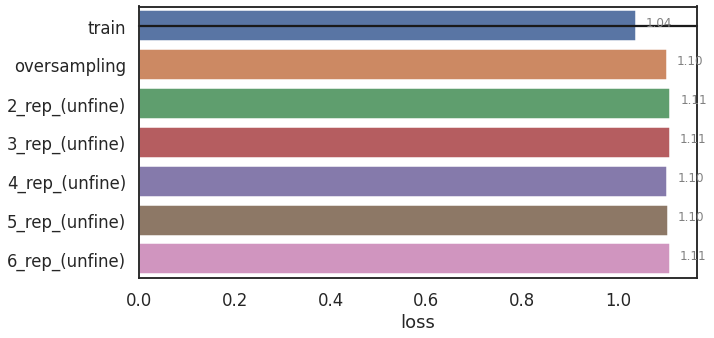

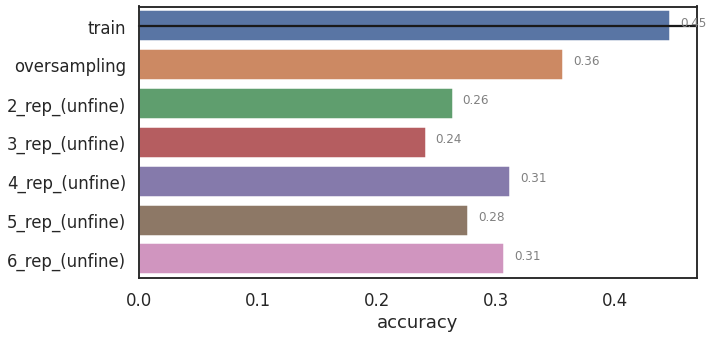

<Figure size 720x360 with 0 Axes>

In [25]:

def Execute():
  # vocab_size = vocab_length + 1 #+1 for the padding 0
  output_size = 3 
  embedding_dim = 200
  hidden_dim = 128
  num_direct = True
  n_layers = 2
  acc_list = []
  batch_size = 32
  patient = 3
  N_EPOCHS = 20
  lr = 0.5e-5
  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_avg_fs = []
  model_list = []
  test_list = [
              'train',
              'oversampling',
              '2_rep_(fine)',
              '3_rep_(fine)',
              '4_rep_(fine)',
              '5_rep_(fine)',
              ]

  task_name = 'twitter'
  tech_name = 'Bert_ data augmentation-master'
  loader = Loader()
  model_path, dataset_path, save_path = loader.path_setting(task_name, tech_name)
  # print('start to loading test dataset')
  df_dev = loader.load_data(save_path, 'dev')
  df_test = loader.load_data(save_path, 'test')
  # print('n.o df_test', len(df_test))
  if tech_name == 'Bert_ data augmentation-master' and task_name == 'rt-polaritydata':
    path_ = path.join(save_path, 'replacement')
  else:
    path_ = save_path

  for file_name in test_list:

    print('-' * 70)
    print('Start to make classification use the data : {}'.format(file_name))
    print('-' * 70)
    # DA and oversampling data"
    df_train = loader.load_data(path_, file_name) 
    df_vocab = pd.concat([df_train, df_dev], axis=0) # I didn't add the test dataset because I think it's happends that we could see the test dataset in practice.
    preprocessor = Preprocessor(df_vocab, 30, None)
    preprocessor.read_data() # in order to get a vocab including all words both in train and test set, preprocessor.vocab
    corpus_indices_train = Preprocessor(df_train, 30, preprocessor.vocab).read_data()
    corpus_indices_valid = Preprocessor(df_dev, 30, preprocessor.vocab).read_data()
    corpus_indices_test = Preprocessor(df_test, 30, preprocessor.vocab).read_data()
    model = SentimentRNN(len(preprocessor.vocab)+1, output_size, embedding_dim, hidden_dim, num_direct, n_layers)
    model.to(device)
    
    trainer = Trainer(model, batch_size, patient, lr, N_EPOCHS, file_name)
    model_, acc, loss, precision, recall, fscore, fscore_avg = trainer.train(corpus_indices_train,
                                                                         corpus_indices_valid, corpus_indices_test, model_path)
    print('-' * 70)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)
    model_list.append(model_)
    acc_list.append(acc)
    loss_list.append(loss)

    list_avg_fs.append(fscore_avg)
  
  # model_test(model_list, corpus_indices_test, test_list)
  print('acc_list', acc_list)
  print('loss_list', loss_list)
  print('precision_list', precision_list)
  print('recall_list', recall_list)
  print('fscore_list', fscore_list)

  print('average fs', list_avg_fs)
  
  utils.draw_final({'loss': loss_list, 'accuracy': acc_list, 'fscore_macro': list_avg_fs}, test_list)

  utils.draw_other_final( {

                    
                    'precision_list': precision_list,
                    'recall': recall_list, 
                    'fscore': fscore_list, 
                    }, test_list)


Execute()

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.033, train_acc:0.464, val Loss: : 1.000955, val_acc: 0.483
[epoch 2] train_loss: 0.970, train_acc:0.522, val Loss: : 0.964683, val_acc: 0.537
[epoch 3] train_loss: 0.917, train_acc:0.556, val Loss: : 0.944509, val_acc: 0.543
[epoch 4] train_loss: 0.862, train_acc:0.598, val Loss: : 0.906452, val_acc: 0.570
[epoch 5] train_loss: 0.809, train_acc:0.635, val Loss: : 0.894327, val_acc: 0.591
[epoch 6] train_loss: 0.747, train_acc:0.668, val Loss: : 0.891596, val_acc: 0.593
[epoch 7] train_loss: 0.685, train_acc:0.703, val Loss: : 0.910443, val_acc: 0.604
[epoch 8] train_loss: 0.623, train_acc:0.733, val Loss: : 0.900687, val_acc: 0.616


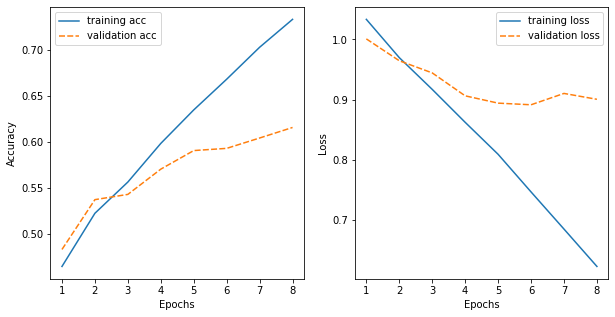

i 0
acc 0.6136254212806933 best_train_acc 0.616717032967033
loss 0.8875263333320618 best_train_loss 0.8915964577879224
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.066, train_acc:0.435, val Loss: : 1.068687, val_acc: 0.441
[epoch 2] train_loss: 0.948, train_acc:0.541, val Loss: : 0.976022, val_acc: 0.519
[epoch 3] train_loss: 0.831, train_acc:0.624, val Loss: : 0.947542, val_acc: 0.531
[epoch 4] train_loss: 0.723, train_acc:0.687, val Loss: : 0.917977, val_acc: 0.586
[epoch 5] train_loss: 0.627, train_acc:0.735, val Loss: : 0.935919, val_acc: 0.589
[epoch 6] train_loss: 0.540, train_acc:0.774, val Loss: : 1.003123, val_acc: 0.598


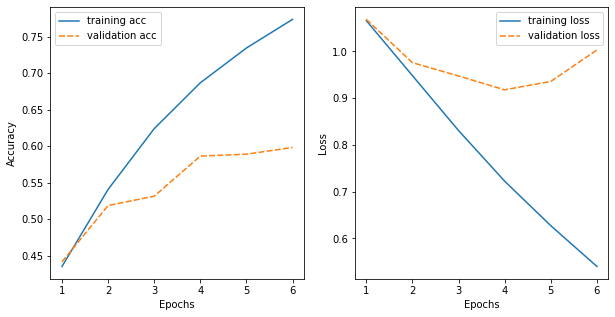

i 0
acc 0.5862622372010913 best_train_acc 0.6221840659340659
loss 1.012176513671875 best_train_loss 0.9179765146512252
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(fine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.064, train_acc:0.430, val Loss: : 1.014769, val_acc: 0.471
[epoch 2] train_loss: 0.951, train_acc:0.541, val Loss: : 0.966657, val_acc: 0.517
[epoch 3] train_loss: 0.843, train_acc:0.613, val Loss: : 0.962622, val_acc: 0.524
[epoch 4] train_loss: 0.743, train_acc:0.668, val Loss: : 0.893157, val_acc: 0.583
[epoch 5] train_loss: 0.650, train_acc:0.720, val Loss: : 0.921531, val_acc: 0.581
[epoch 6] train_loss: 0.568, train_acc:0.761, val Loss: : 0.932241, val_acc: 0.604


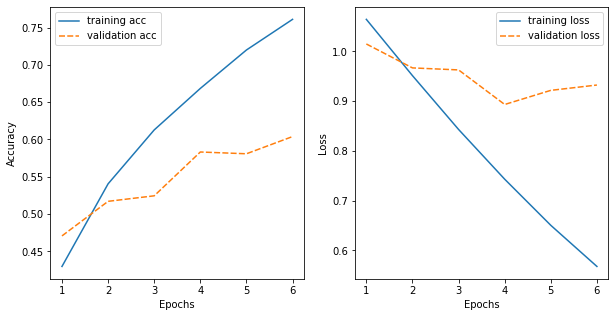

i 0
acc 0.6023110255175734 best_train_acc 0.6121565934065933
loss 0.9468325972557068 best_train_loss 0.8931565831650744
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(fine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.059, train_acc:0.437, val Loss: : 1.034590, val_acc: 0.468
[epoch 2] train_loss: 0.930, train_acc:0.556, val Loss: : 0.980365, val_acc: 0.518
[epoch 3] train_loss: 0.825, train_acc:0.625, val Loss: : 0.974316, val_acc: 0.517
[epoch 4] train_loss: 0.739, train_acc:0.670, val Loss: : 0.910534, val_acc: 0.572
[epoch 5] train_loss: 0.641, train_acc:0.727, val Loss: : 0.958462, val_acc: 0.578
[epoch 6] train_loss: 0.562, train_acc:0.760, val Loss: : 0.910421, val_acc: 0.609
[epoch 7] train_loss: 0.488, train_acc:0.798, val Loss: : 0.979157, val_acc: 0.614
[epoch 8] train_loss: 0.423, 

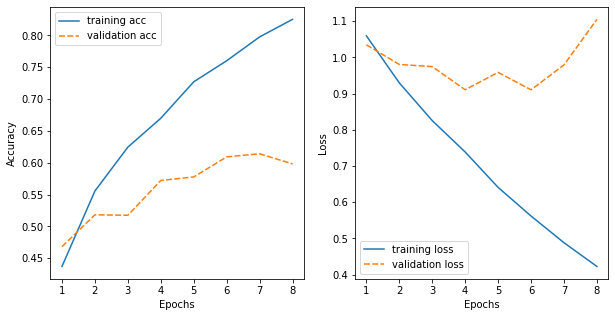

i 0
acc 0.595971754132563 best_train_acc 0.6158585164835165
loss 1.1165046691894531 best_train_loss 0.9104207953908942
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(fine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.054, train_acc:0.443, val Loss: : 1.035875, val_acc: 0.450
[epoch 2] train_loss: 0.934, train_acc:0.551, val Loss: : 1.049005, val_acc: 0.474
[epoch 3] train_loss: 0.841, train_acc:0.615, val Loss: : 0.951632, val_acc: 0.533
[epoch 4] train_loss: 0.735, train_acc:0.675, val Loss: : 0.924944, val_acc: 0.583
[epoch 5] train_loss: 0.635, train_acc:0.728, val Loss: : 0.933640, val_acc: 0.590
[epoch 6] train_loss: 0.572, train_acc:0.758, val Loss: : 0.967366, val_acc: 0.590


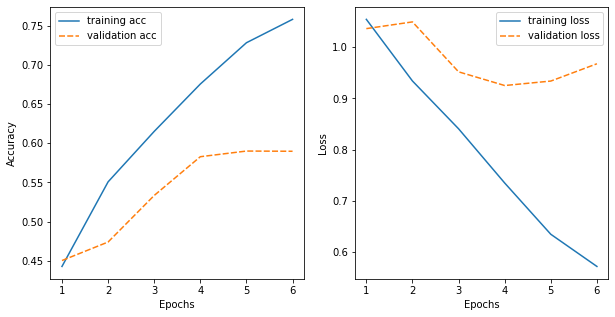

i 0
acc 0.5958112662493982 best_train_acc 0.6100480769230769
loss 0.9060181975364685 best_train_loss 0.9249438872704139
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(fine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.067, train_acc:0.427, val Loss: : 1.063599, val_acc: 0.460
[epoch 2] train_loss: 0.936, train_acc:0.553, val Loss: : 0.966826, val_acc: 0.527
[epoch 3] train_loss: 0.822, train_acc:0.626, val Loss: : 0.911541, val_acc: 0.564
[epoch 4] train_loss: 0.727, train_acc:0.681, val Loss: : 0.909181, val_acc: 0.581
[epoch 5] train_loss: 0.654, train_acc:0.719, val Loss: : 0.939474, val_acc: 0.569
[epoch 6] train_loss: 0.583, train_acc:0.754, val Loss: : 0.957388, val_acc: 0.589


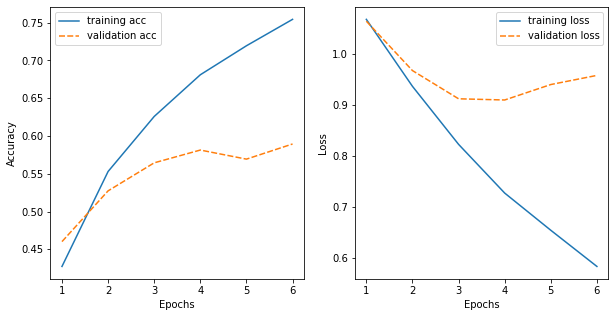

i 0
acc 0.6137056652222758 best_train_acc 0.6221634615384616
loss 0.9683785438537598 best_train_loss 0.9091808042683445
----------------------------------------------------------------------
acc_list [0.6136254212806933, 0.5862622372010913, 0.6023110255175734, 0.595971754132563, 0.5958112662493982, 0.6137056652222758]
loss_list [tensor(0.8875, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.0122, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9468, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1165, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9060, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9684, device='cuda:0', grad_fn=<NllLossBackward>)]
precision_list [array([0.46989374, 0.64307381, 0.62784444]), array([0.40700916, 0.65910982, 0.60567762]), array([0.50622407, 0.63817764, 0.58670004]), array([0.38030798, 0.62968418, 0.65684411]), array([0.44415449, 0.62096642, 0.62666066]), array([0.4576183 , 0.62911473, 0.66129409])]
recall_list [array([0.4

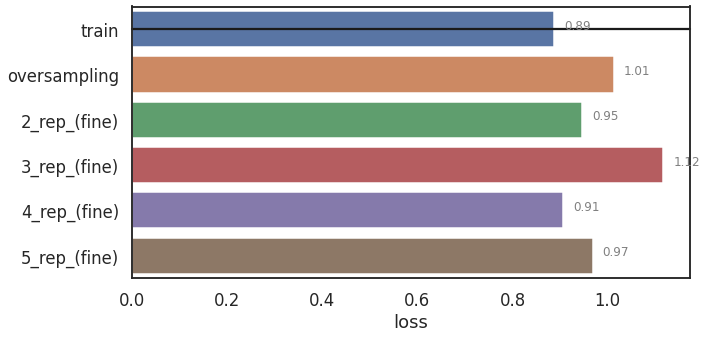

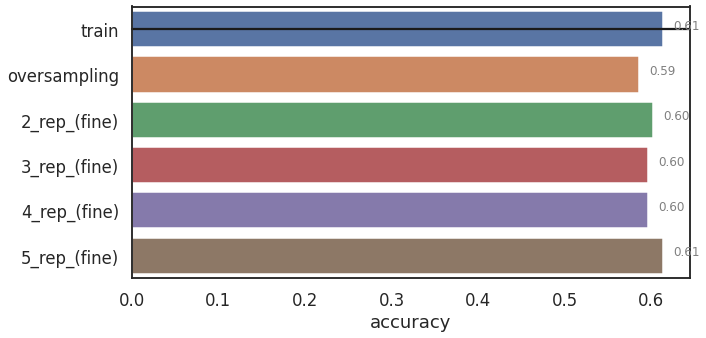

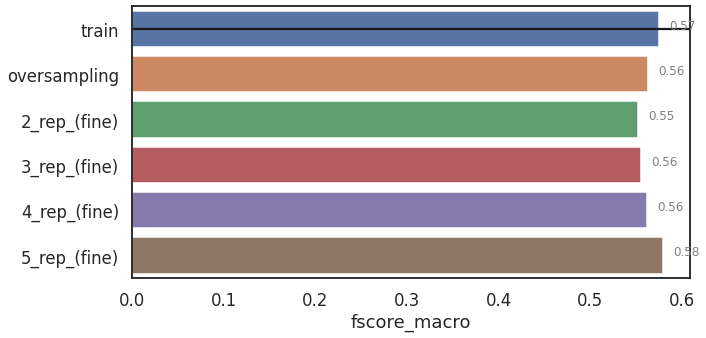

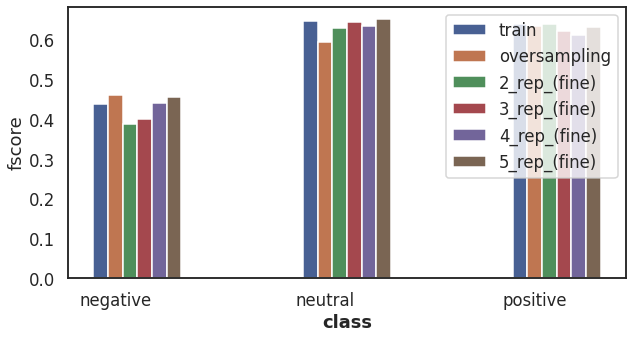

In [0]:
# fine tune BERT SECOND TEST

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.033, train_acc:0.471, val Loss: : 1.002169, val_acc: 0.494
[epoch 2] train_loss: 0.977, train_acc:0.512, val Loss: : 0.973360, val_acc: 0.514
[epoch 3] train_loss: 0.911, train_acc:0.562, val Loss: : 0.928251, val_acc: 0.546
[epoch 4] train_loss: 0.850, train_acc:0.604, val Loss: : 0.918777, val_acc: 0.559
[epoch 5] train_loss: 0.783, train_acc:0.652, val Loss: : 0.887962, val_acc: 0.588
[epoch 6] train_loss: 0.723, train_acc:0.684, val Loss: : 0.898840, val_acc: 0.588
[epoch 7] train_loss: 0.669, train_acc:0.714, val Loss: : 0.909523, val_acc: 0.592
[epoch 8] train_loss: 0.606, train_acc:0.746, val Loss: : 0.887058, val_acc: 0.605
[epoch 9] train_loss: 0.543, train_acc:0.776, val Loss: : 0.922605, val_acc: 0.631
[epoch 10] train_loss: 0.484, train_acc:0.801, val Loss: : 0.

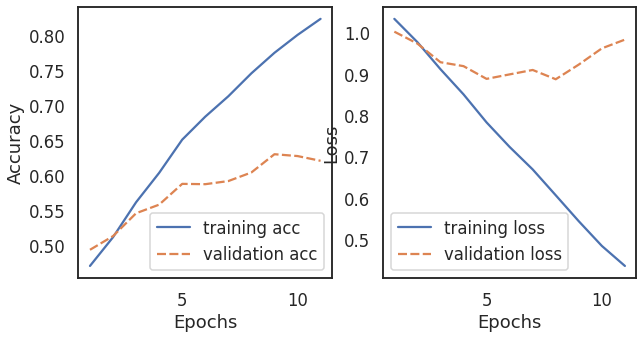

i 0
acc 0.6126624939817044 best_train_acc 0.6307692307692307
loss 1.0487147569656372 best_train_loss 0.8870584067407545
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.057, train_acc:0.435, val Loss: : 1.071601, val_acc: 0.420
[epoch 2] train_loss: 0.951, train_acc:0.537, val Loss: : 1.003659, val_acc: 0.488
[epoch 3] train_loss: 0.835, train_acc:0.618, val Loss: : 0.959138, val_acc: 0.550
[epoch 4] train_loss: 0.732, train_acc:0.680, val Loss: : 0.930256, val_acc: 0.580
[epoch 5] train_loss: 0.628, train_acc:0.730, val Loss: : 0.920499, val_acc: 0.606
[epoch 6] train_loss: 0.539, train_acc:0.775, val Loss: : 1.021162, val_acc: 0.582
[epoch 7] train_loss: 0.475, train_acc:0.801, val Loss: : 1.047459, val_acc: 0.605


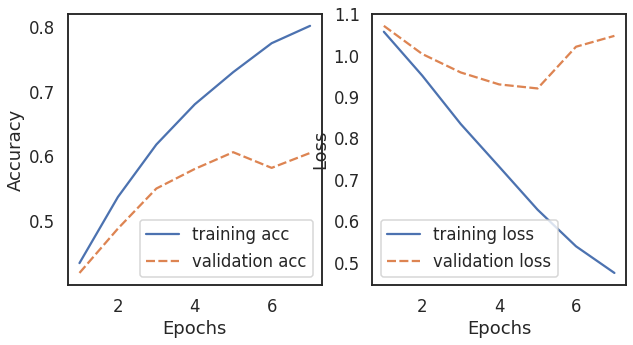

i 0
acc 0.5603434440699727 best_train_acc 0.6062225274725276
loss 1.1031670570373535 best_train_loss 0.920498897086133
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(fine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.060, train_acc:0.435, val Loss: : 1.042300, val_acc: 0.460
[epoch 2] train_loss: 0.940, train_acc:0.549, val Loss: : 0.984398, val_acc: 0.521
[epoch 3] train_loss: 0.830, train_acc:0.625, val Loss: : 0.942386, val_acc: 0.566
[epoch 4] train_loss: 0.734, train_acc:0.681, val Loss: : 0.871735, val_acc: 0.603
[epoch 5] train_loss: 0.648, train_acc:0.723, val Loss: : 0.901956, val_acc: 0.621
[epoch 6] train_loss: 0.558, train_acc:0.766, val Loss: : 0.914350, val_acc: 0.630
[epoch 7] train_loss: 0.482, train_acc:0.802, val Loss: : 0.961367, val_acc: 0.613
[epoch 8] train_loss: 0.410, t

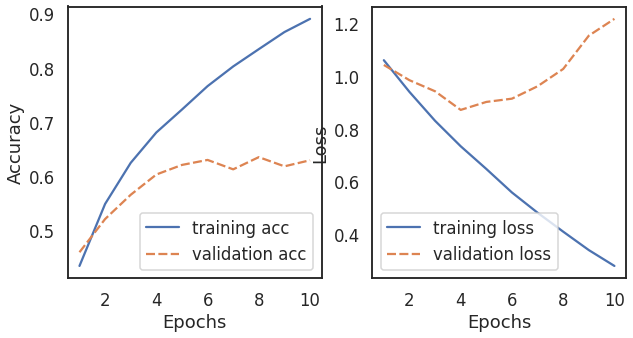

i 0
acc 0.6173968865350666 best_train_acc 0.6353846153846154
loss 1.3508903980255127 best_train_loss 0.8717351310200744
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(fine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.059, train_acc:0.437, val Loss: : 1.047335, val_acc: 0.452
[epoch 2] train_loss: 0.935, train_acc:0.552, val Loss: : 0.982239, val_acc: 0.512
[epoch 3] train_loss: 0.831, train_acc:0.620, val Loss: : 0.952770, val_acc: 0.553
[epoch 4] train_loss: 0.740, train_acc:0.676, val Loss: : 0.970238, val_acc: 0.557
[epoch 5] train_loss: 0.647, train_acc:0.726, val Loss: : 0.933211, val_acc: 0.611
[epoch 6] train_loss: 0.576, train_acc:0.753, val Loss: : 0.946000, val_acc: 0.602
[epoch 7] train_loss: 0.519, train_acc:0.782, val Loss: : 0.963470, val_acc: 0.623
[epoch 8] train_loss: 0.461, 

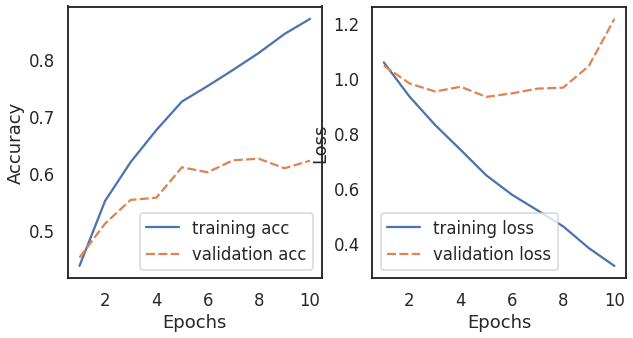

i 0
acc 0.6009468785106724 best_train_acc 0.6257211538461538
loss 1.2081780433654785 best_train_loss 0.9332105817048104
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(fine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.062, train_acc:0.429, val Loss: : 1.078403, val_acc: 0.446
[epoch 2] train_loss: 0.943, train_acc:0.546, val Loss: : 0.976584, val_acc: 0.507
[epoch 3] train_loss: 0.832, train_acc:0.619, val Loss: : 1.014570, val_acc: 0.507
[epoch 4] train_loss: 0.742, train_acc:0.671, val Loss: : 1.012108, val_acc: 0.533
[epoch 5] train_loss: 0.651, train_acc:0.718, val Loss: : 0.947437, val_acc: 0.583
[epoch 6] train_loss: 0.569, train_acc:0.758, val Loss: : 1.008739, val_acc: 0.578
[epoch 7] train_loss: 0.497, train_acc:0.790, val Loss: : 1.049412, val_acc: 0.567
[epoch 8] train_loss: 0.423, 

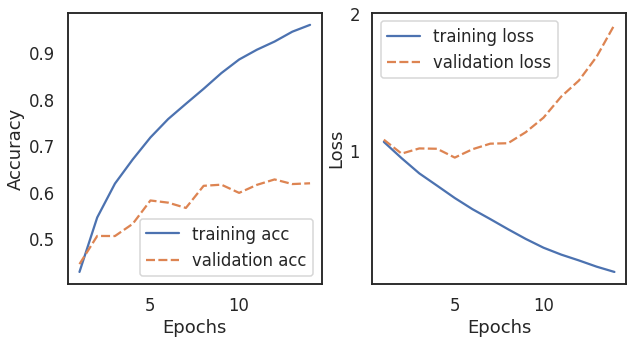

i 0
acc 0.5897929706307173 best_train_acc 0.6279532967032967
loss 1.9871230125427246 best_train_loss 0.9474370237235185
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(fine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.061, train_acc:0.433, val Loss: : 1.073493, val_acc: 0.440
[epoch 2] train_loss: 0.944, train_acc:0.541, val Loss: : 1.027695, val_acc: 0.485
[epoch 3] train_loss: 0.845, train_acc:0.612, val Loss: : 0.908044, val_acc: 0.566
[epoch 4] train_loss: 0.754, train_acc:0.664, val Loss: : 0.930632, val_acc: 0.566
[epoch 5] train_loss: 0.653, train_acc:0.720, val Loss: : 0.913372, val_acc: 0.595
[epoch 6] train_loss: 0.580, train_acc:0.753, val Loss: : 0.974567, val_acc: 0.581
[epoch 7] train_loss: 0.515, train_acc:0.785, val Loss: : 1.006555, val_acc: 0.589
[epoch 8] train_loss: 0.452, 

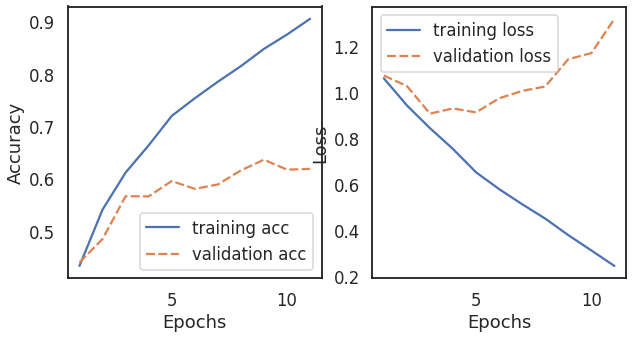

i 0
acc 0.591478093403948 best_train_acc 0.6361950549450549
loss 1.4520434141159058 best_train_loss 0.9080438089894725
----------------------------------------------------------------------
acc_list [0.6126624939817044, 0.5603434440699727, 0.6173968865350666, 0.6009468785106724, 0.5897929706307173, 0.591478093403948]
loss_list [tensor(1.0487, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1032, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.3509, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2082, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9871, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4520, device='cuda:0', grad_fn=<NllLossBackward>)]
precision_list [array([0.5       , 0.63722185, 0.61509949]), array([0.34008594, 0.66853522, 0.61399726]), array([0.48165138, 0.60288714, 0.69892473]), array([0.43378227, 0.62046363, 0.64067797]), array([0.45260989, 0.63221997, 0.58439234]), array([0.43089054, 0.64334862, 0.60622783])]
recall_list [array([0.36

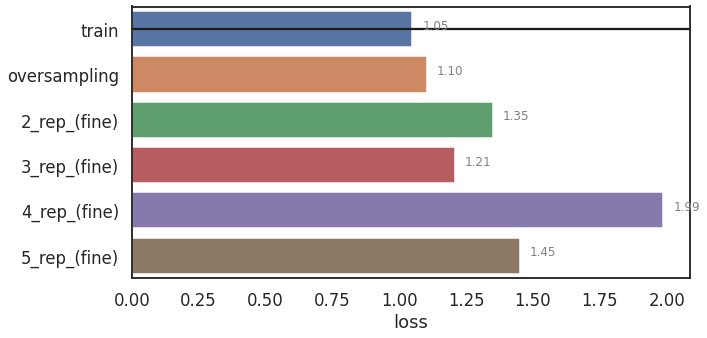

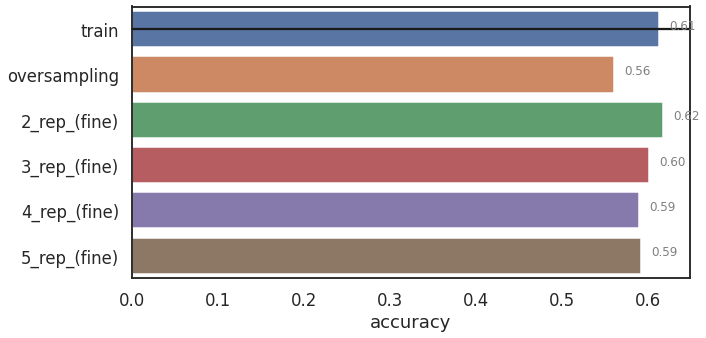

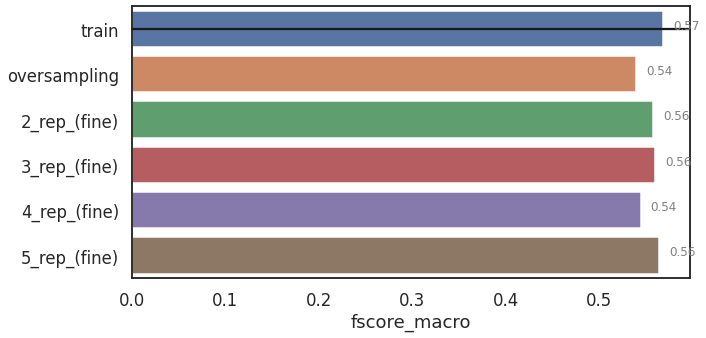

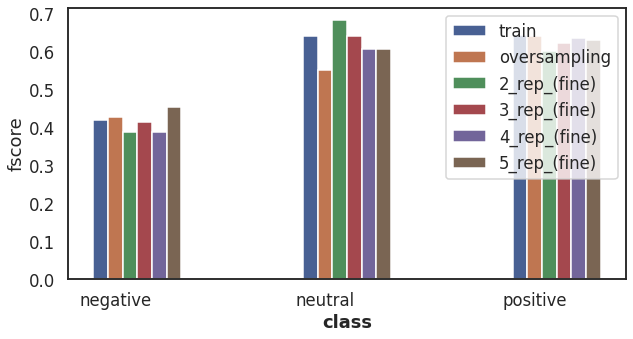

In [0]:
# fine tune da 第一次结果

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.035, train_acc:0.471, val Loss: : 0.994031, val_acc: 0.504
[epoch 2] train_loss: 0.962, train_acc:0.529, val Loss: : 0.948217, val_acc: 0.540
[epoch 3] train_loss: 0.907, train_acc:0.570, val Loss: : 0.915070, val_acc: 0.563
[epoch 4] train_loss: 0.842, train_acc:0.611, val Loss: : 0.894272, val_acc: 0.582
[epoch 5] train_loss: 0.790, train_acc:0.644, val Loss: : 0.888950, val_acc: 0.605
[epoch 6] train_loss: 0.735, train_acc:0.676, val Loss: : 0.861232, val_acc: 0.609
[epoch 7] train_loss: 0.685, train_acc:0.702, val Loss: : 0.867110, val_acc: 0.603
[epoch 8] train_loss: 0.627, train_acc:0.733, val Loss: : 0.869905, val_acc: 0.625


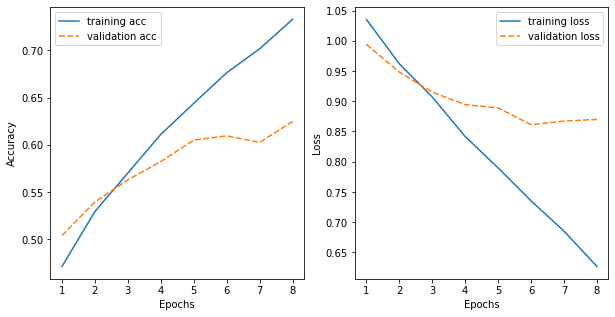

i 0
acc 0.5979778526721232 best_train_acc 0.624690934065934
loss 0.9699013233184814 best_train_loss 0.8612323016910762
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.063, train_acc:0.434, val Loss: : 1.068124, val_acc: 0.437
[epoch 2] train_loss: 0.949, train_acc:0.543, val Loss: : 1.007941, val_acc: 0.483
[epoch 3] train_loss: 0.839, train_acc:0.615, val Loss: : 1.043526, val_acc: 0.499
[epoch 4] train_loss: 0.749, train_acc:0.670, val Loss: : 0.964842, val_acc: 0.532
[epoch 5] train_loss: 0.667, train_acc:0.713, val Loss: : 0.934757, val_acc: 0.601
[epoch 6] train_loss: 0.576, train_acc:0.756, val Loss: : 0.956210, val_acc: 0.585
[epoch 7] train_loss: 0.493, train_acc:0.796, val Loss: : 1.006604, val_acc: 0.623


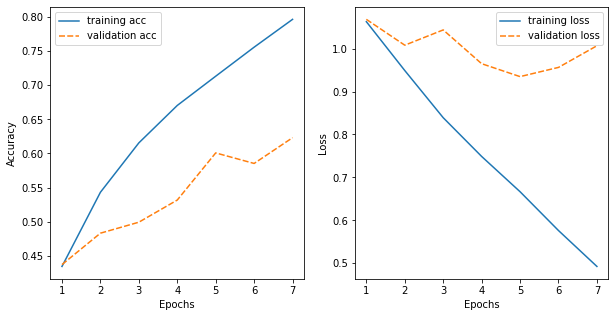

i 0
acc 0.557454662173006 best_train_acc 0.6230975274725274
loss 1.1175907850265503 best_train_loss 0.9347574455397469
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.067, train_acc:0.426, val Loss: : 1.070594, val_acc: 0.442
[epoch 2] train_loss: 0.952, train_acc:0.542, val Loss: : 0.924683, val_acc: 0.538
[epoch 3] train_loss: 0.842, train_acc:0.618, val Loss: : 0.943610, val_acc: 0.536
[epoch 4] train_loss: 0.747, train_acc:0.673, val Loss: : 0.925719, val_acc: 0.574
[epoch 5] train_loss: 0.667, train_acc:0.714, val Loss: : 0.829987, val_acc: 0.621
[epoch 6] train_loss: 0.581, train_acc:0.758, val Loss: : 0.908264, val_acc: 0.614
[epoch 7] train_loss: 0.505, train_acc:0.795, val Loss: : 0.945027, val_acc: 0.611


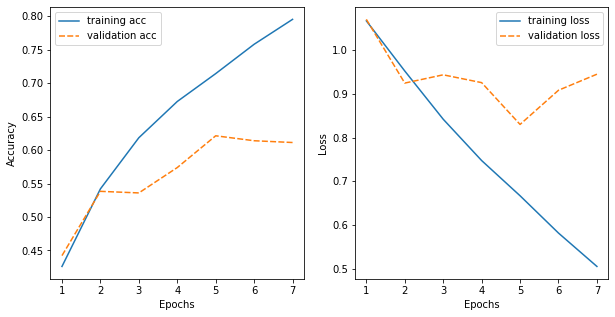

i 0
acc 0.6352912855079441 best_train_acc 0.6467445054945056
loss 0.8793619275093079 best_train_loss 0.8299871149298909
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.065, train_acc:0.423, val Loss: : 1.090923, val_acc: 0.437
[epoch 2] train_loss: 0.936, train_acc:0.547, val Loss: : 0.971094, val_acc: 0.505
[epoch 3] train_loss: 0.842, train_acc:0.615, val Loss: : 0.901214, val_acc: 0.562
[epoch 4] train_loss: 0.760, train_acc:0.660, val Loss: : 0.867616, val_acc: 0.591
[epoch 5] train_loss: 0.672, train_acc:0.710, val Loss: : 0.864080, val_acc: 0.605
[epoch 6] train_loss: 0.585, train_acc:0.755, val Loss: : 0.842864, val_acc: 0.636
[epoch 7] train_loss: 0.507, train_acc:0.789, val Loss: : 0.887543, val_acc: 0.644
[epoch 8] train_loss: 0.433, train_a

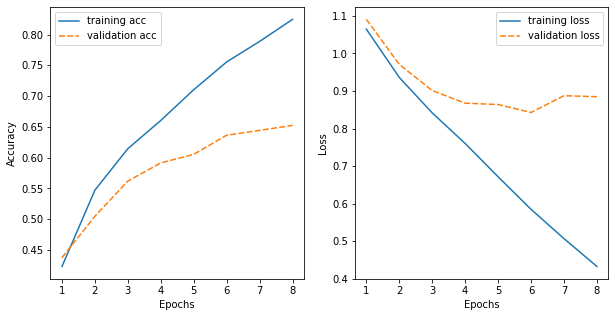

i 0
acc 0.6013480982185845 best_train_acc 0.6524107142857143
loss 0.9697022438049316 best_train_loss 0.8428640198576581
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.058, train_acc:0.432, val Loss: : 1.031666, val_acc: 0.460
[epoch 2] train_loss: 0.926, train_acc:0.553, val Loss: : 0.962494, val_acc: 0.527
[epoch 3] train_loss: 0.831, train_acc:0.622, val Loss: : 1.033813, val_acc: 0.493
[epoch 4] train_loss: 0.751, train_acc:0.667, val Loss: : 0.937159, val_acc: 0.573
[epoch 5] train_loss: 0.660, train_acc:0.721, val Loss: : 0.891270, val_acc: 0.609
[epoch 6] train_loss: 0.582, train_acc:0.758, val Loss: : 0.903958, val_acc: 0.600
[epoch 7] train_loss: 0.513, train_acc:0.790, val Loss: : 0.871935, val_acc: 0.642
[epoch 8] train_loss: 0.441, train_a

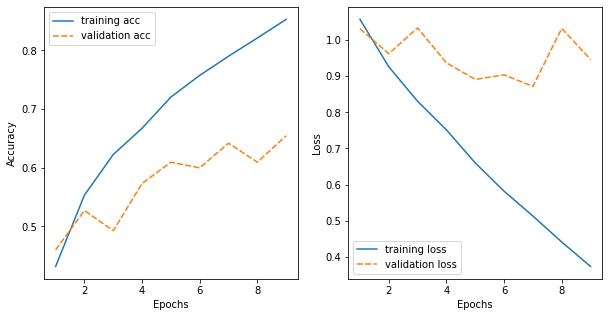

i 0
acc 0.6081688332530893 best_train_acc 0.6545398351648352
loss 1.112112283706665 best_train_loss 0.8719349966926889
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.056, train_acc:0.432, val Loss: : 1.083416, val_acc: 0.422
[epoch 2] train_loss: 0.924, train_acc:0.552, val Loss: : 1.060785, val_acc: 0.451
[epoch 3] train_loss: 0.816, train_acc:0.629, val Loss: : 0.923937, val_acc: 0.559
[epoch 4] train_loss: 0.726, train_acc:0.681, val Loss: : 0.921134, val_acc: 0.575
[epoch 5] train_loss: 0.646, train_acc:0.722, val Loss: : 0.920465, val_acc: 0.583
[epoch 6] train_loss: 0.573, train_acc:0.757, val Loss: : 0.954300, val_acc: 0.597
[epoch 7] train_loss: 0.499, train_acc:0.795, val Loss: : 0.919643, val_acc: 0.619
[epoch 8] train_loss: 0.428, train_ac

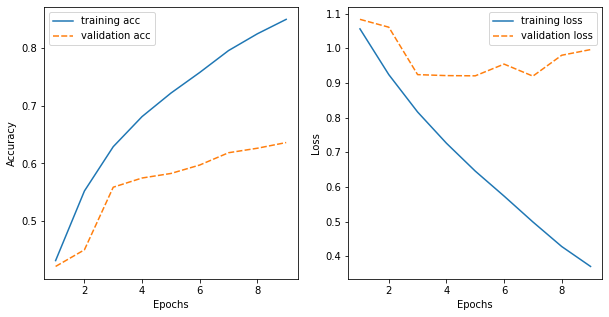

i 0
acc 0.5778366233349382 best_train_acc 0.6361195054945056
loss 1.1562613248825073 best_train_loss 0.9196426601527812
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 6_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.056, train_acc:0.432, val Loss: : 1.008116, val_acc: 0.483
[epoch 2] train_loss: 0.942, train_acc:0.539, val Loss: : 0.981105, val_acc: 0.505
[epoch 3] train_loss: 0.838, train_acc:0.611, val Loss: : 0.951508, val_acc: 0.544
[epoch 4] train_loss: 0.748, train_acc:0.665, val Loss: : 0.988269, val_acc: 0.547
[epoch 5] train_loss: 0.660, train_acc:0.716, val Loss: : 0.934046, val_acc: 0.585
[epoch 6] train_loss: 0.586, train_acc:0.753, val Loss: : 0.903806, val_acc: 0.603
[epoch 7] train_loss: 0.507, train_acc:0.788, val Loss: : 0.918012, val_acc: 0.610
[epoch 8] train_loss: 0.438, train_a

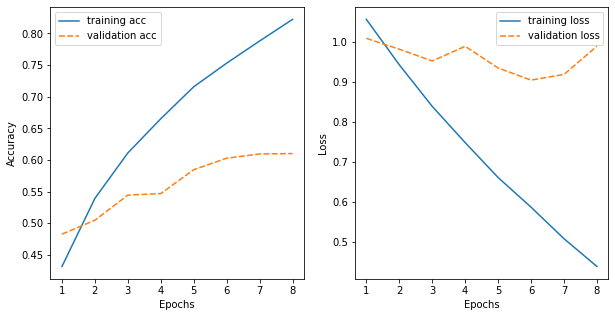

i 0
acc 0.6081688332530893 best_train_acc 0.6282692307692308
loss 1.030868411064148 best_train_loss 0.9038063870681511
----------------------------------------------------------------------
acc_list [0.5979778526721232, 0.557454662173006, 0.6352912855079441, 0.6013480982185845, 0.6081688332530893, 0.5778366233349382, 0.6081688332530893]
loss_list [tensor(0.9699, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.8794, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9697, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1121, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1563, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.0309, device='cuda:0', grad_fn=<NllLossBackward>)]
precision_list [array([0.42390671, 0.58384394, 0.74763636]), array([0.31978664, 0.65662651, 0.68094853]), array([0.51610487, 0.68106759, 0.65270506]), array([0.42064897, 0.69291695, 0.64603482]), array([0.41709537, 0.67349374, 0.6

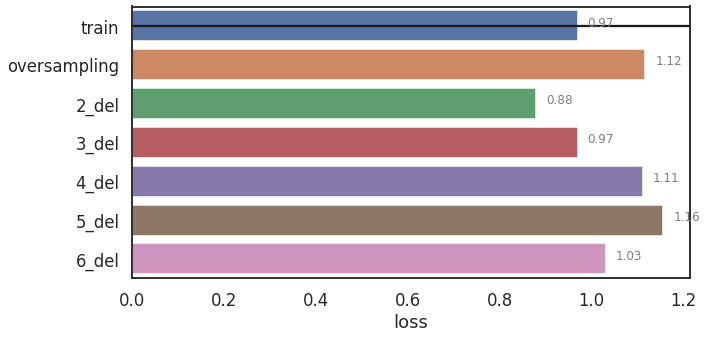

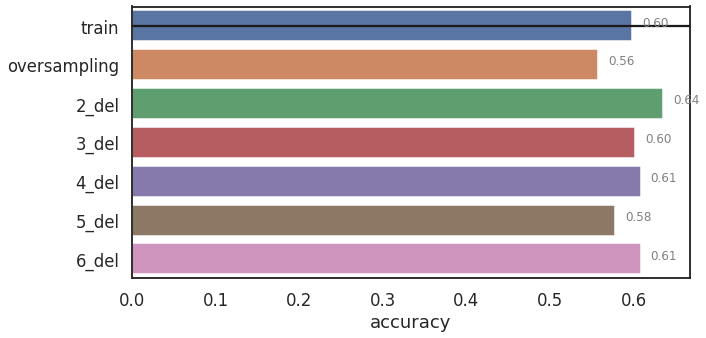

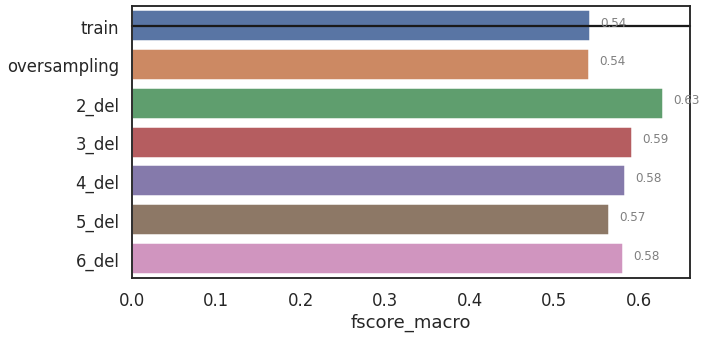

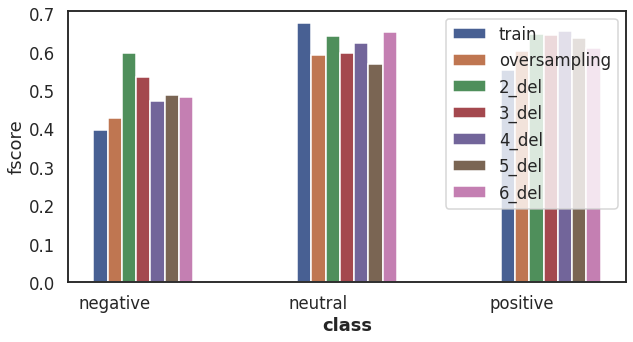

In [0]:
# deletion augmentation 的结果。 又跑了一遍，消除偶然误差

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.030, train_acc:0.481, val Loss: : 0.992523, val_acc: 0.500
[epoch 2] train_loss: 0.959, train_acc:0.535, val Loss: : 0.949965, val_acc: 0.533
[epoch 3] train_loss: 0.909, train_acc:0.564, val Loss: : 0.943508, val_acc: 0.542
[epoch 4] train_loss: 0.844, train_acc:0.607, val Loss: : 0.899773, val_acc: 0.581
[epoch 5] train_loss: 0.784, train_acc:0.645, val Loss: : 0.874224, val_acc: 0.599
[epoch 6] train_loss: 0.730, train_acc:0.675, val Loss: : 0.883996, val_acc: 0.605
[epoch 7] train_loss: 0.673, train_acc:0.706, val Loss: : 0.881017, val_acc: 0.604


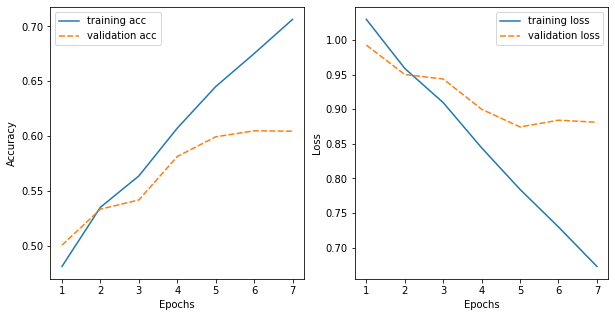

i 0
acc 0.6058417589471995 best_train_acc 0.6069093406593408
loss 0.8781238198280334 best_train_loss 0.8742237428387443
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.065, train_acc:0.430, val Loss: : 1.052774, val_acc: 0.453
[epoch 2] train_loss: 0.950, train_acc:0.542, val Loss: : 0.980470, val_acc: 0.521
[epoch 3] train_loss: 0.840, train_acc:0.618, val Loss: : 0.959162, val_acc: 0.534
[epoch 4] train_loss: 0.739, train_acc:0.674, val Loss: : 0.950158, val_acc: 0.566
[epoch 5] train_loss: 0.630, train_acc:0.734, val Loss: : 0.955188, val_acc: 0.595
[epoch 6] train_loss: 0.538, train_acc:0.776, val Loss: : 0.947965, val_acc: 0.611
[epoch 7] train_loss: 0.482, train_acc:0.798, val Loss: : 1.002677, val_acc: 0.620
[epoch 8] train_loss: 0.416, 

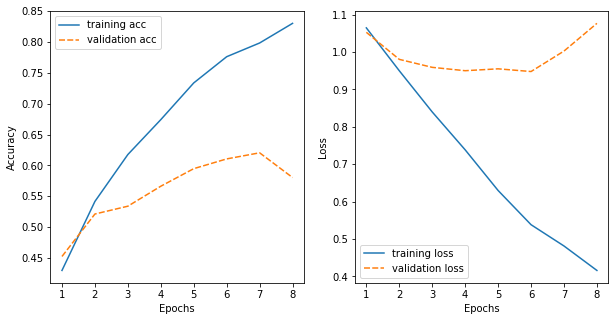

i 0
acc 0.6127427379232868 best_train_acc 0.6242719780219781
loss 1.113682746887207 best_train_loss 0.9479648788551708
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.070, train_acc:0.423, val Loss: : 1.087344, val_acc: 0.435
[epoch 2] train_loss: 0.955, train_acc:0.539, val Loss: : 0.975493, val_acc: 0.524
[epoch 3] train_loss: 0.846, train_acc:0.613, val Loss: : 0.895172, val_acc: 0.574
[epoch 4] train_loss: 0.764, train_acc:0.661, val Loss: : 0.995472, val_acc: 0.535
[epoch 5] train_loss: 0.702, train_acc:0.697, val Loss: : 0.908815, val_acc: 0.580


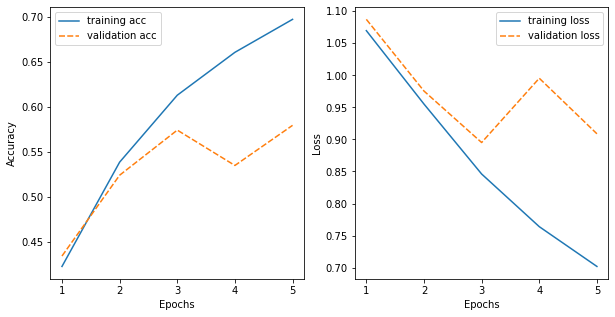

i 0
acc 0.5750280853795539 best_train_acc 0.5798763736263736
loss 0.9855577349662781 best_train_loss 0.8951724469661713
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.064, train_acc:0.425, val Loss: : 1.005856, val_acc: 0.486
[epoch 2] train_loss: 0.946, train_acc:0.539, val Loss: : 1.057894, val_acc: 0.466
[epoch 3] train_loss: 0.840, train_acc:0.612, val Loss: : 0.960138, val_acc: 0.542
[epoch 4] train_loss: 0.754, train_acc:0.666, val Loss: : 0.938847, val_acc: 0.566
[epoch 5] train_loss: 0.669, train_acc:0.709, val Loss: : 0.930913, val_acc: 0.603
[epoch 6] train_loss: 0.594, train_acc:0.749, val Loss: : 0.998705, val_acc: 0.581
[epoch 7] train_loss: 0.517, train_acc:0.788, val Loss: : 0.931977, val_acc: 0.607
[epoch 8] train_loss: 0.454, train_a

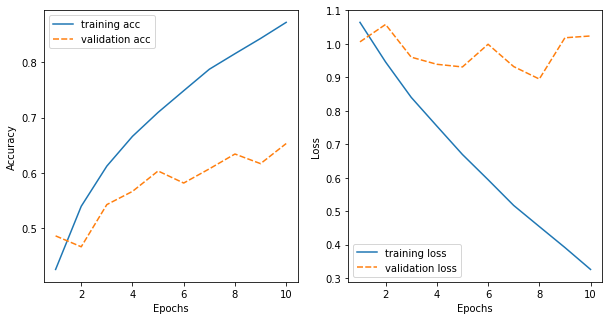

i 0
acc 0.6401861659444712 best_train_acc 0.6629052197802198
loss 1.05778169631958 best_train_loss 0.8948187705252196
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.061, train_acc:0.429, val Loss: : 1.008682, val_acc: 0.481
[epoch 2] train_loss: 0.941, train_acc:0.546, val Loss: : 0.985643, val_acc: 0.503
[epoch 3] train_loss: 0.819, train_acc:0.627, val Loss: : 0.921527, val_acc: 0.565
[epoch 4] train_loss: 0.730, train_acc:0.681, val Loss: : 0.895893, val_acc: 0.597
[epoch 5] train_loss: 0.646, train_acc:0.724, val Loss: : 0.897899, val_acc: 0.607
[epoch 6] train_loss: 0.563, train_acc:0.765, val Loss: : 0.906682, val_acc: 0.605
[epoch 7] train_loss: 0.490, train_acc:0.801, val Loss: : 0.879217, val_acc: 0.638
[epoch 8] train_loss: 0.440, train_acc

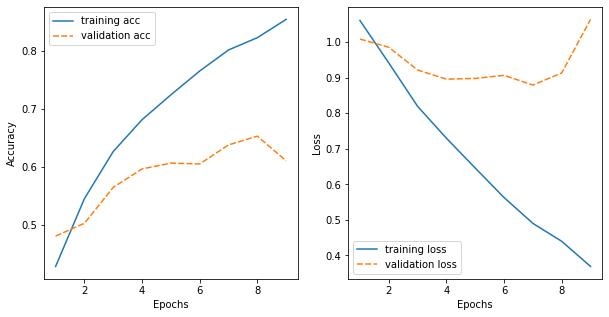

i 0
acc 0.6200449366072861 best_train_acc 0.653021978021978
loss 0.9819517135620117 best_train_loss 0.8792173443259773
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.059, train_acc:0.426, val Loss: : 1.066930, val_acc: 0.452
[epoch 2] train_loss: 0.930, train_acc:0.550, val Loss: : 1.051053, val_acc: 0.458
[epoch 3] train_loss: 0.824, train_acc:0.623, val Loss: : 0.945040, val_acc: 0.545
[epoch 4] train_loss: 0.741, train_acc:0.672, val Loss: : 0.895254, val_acc: 0.582
[epoch 5] train_loss: 0.655, train_acc:0.719, val Loss: : 0.892737, val_acc: 0.589
[epoch 6] train_loss: 0.586, train_acc:0.750, val Loss: : 0.924121, val_acc: 0.599
[epoch 7] train_loss: 0.522, train_acc:0.781, val Loss: : 1.010136, val_acc: 0.586


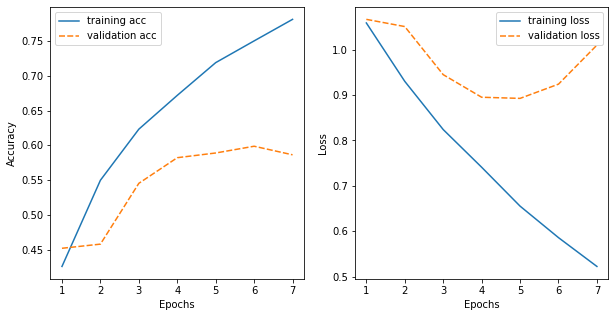

i 0
acc 0.6303964050714171 best_train_acc 0.6370260989010988
loss 0.907822847366333 best_train_loss 0.8927365977030534
----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 6_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.056, train_acc:0.432, val Loss: : 1.010033, val_acc: 0.483
[epoch 2] train_loss: 0.947, train_acc:0.536, val Loss: : 0.981505, val_acc: 0.482
[epoch 3] train_loss: 0.843, train_acc:0.610, val Loss: : 0.935633, val_acc: 0.549
[epoch 4] train_loss: 0.757, train_acc:0.666, val Loss: : 0.990112, val_acc: 0.536
[epoch 5] train_loss: 0.678, train_acc:0.710, val Loss: : 0.899993, val_acc: 0.587
[epoch 6] train_loss: 0.609, train_acc:0.741, val Loss: : 0.932252, val_acc: 0.587
[epoch 7] train_loss: 0.531, train_acc:0.783, val Loss: : 0.902321, val_acc: 0.613


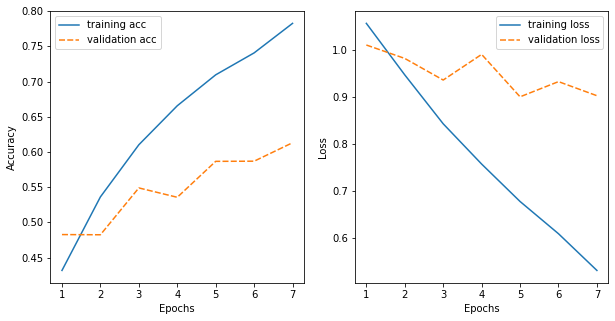

i 0
acc 0.5975766329642112 best_train_acc 0.6168406593406593
loss 0.9480380415916443 best_train_loss 0.8999928419406598
----------------------------------------------------------------------
acc_list [0.6058417589471995, 0.6127427379232868, 0.5750280853795539, 0.6401861659444712, 0.6200449366072861, 0.6303964050714171, 0.5975766329642112]
loss_list [tensor(0.8781, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1137, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9856, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.0578, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9820, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9078, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9480, device='cuda:0', grad_fn=<NllLossBackward>)]
precision_list [array([0.40922683, 0.64261518, 0.66350486]), array([0.48690476, 0.61201299, 0.66674988]), array([0.37139452, 0.66882104, 0.68968254]), array([0.5515032 , 0.65821297, 0.65639652]), array([0.54071661, 0.65267519, 0

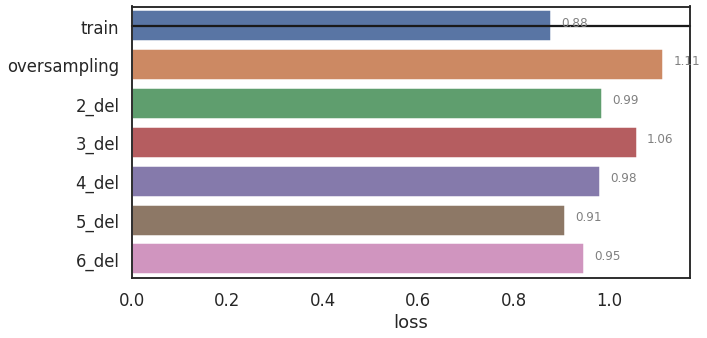

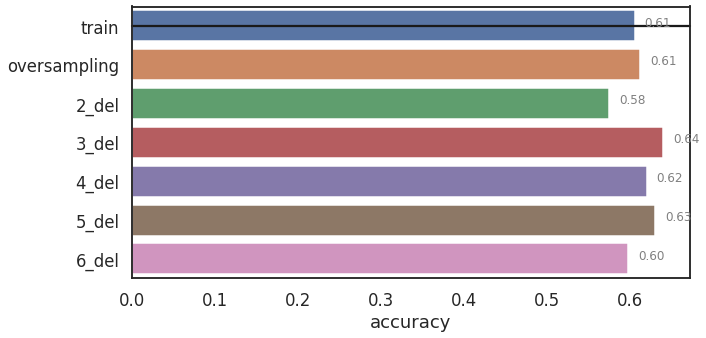

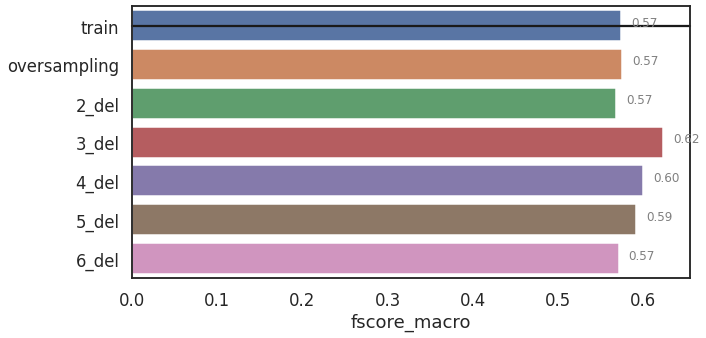

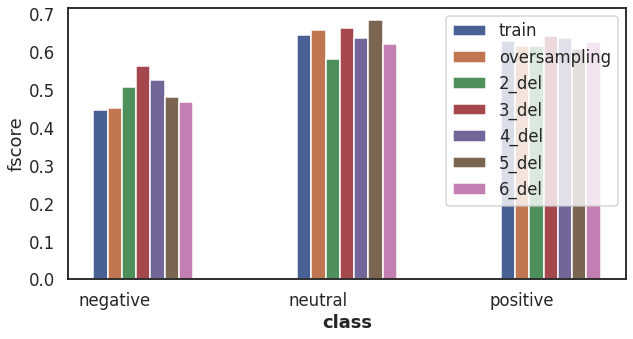

In [0]:
# 这是在 deletion 的 DA 下，利用 LSTM 进行分类的结果。

In [0]:
train: acc 0.610255175734232 best_train_acc 0.6193406593406593, loss tensor(0.8794) best_train_loss 0.8746820933871217
over: acc 0.5715775958915101 best_train_acc 0.6190041208791208, loss tensor(0.9558) best_train_loss 0.882892682329639


acc 0.6133044455143637 best_train_acc 0.6310233516483517
loss 0.9101547002792358 best_train_loss 0.8615971761090415
over:
acc 0.6072059059541005 best_train_acc 0.6350137362637363
loss 0.9558061957359314 best_train_loss 0.8600593225641565